# <font  color = "#0093AF"> REDOR

In [1]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=sl.PowderAvg('bcr20'),n_gamma=30)
# After varying the powder average and n_gamma, a beta-average and 30 gamma angles seems sufficient
# The beta-only average may not be valid for slower motion (??)
delta=sl.Tools.dipole_coupling(.102,'15N','1H')
phi=35*np.pi/180
S=-1/2+3/2*np.cos(phi)**2
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex,kex=sl.Tools.Setup3siteSym(ex0,tc=1e-9,phi=phi)

L=sl.Liouvillian(ex,kex=kex)

v1=150e3 #100 kHz pulse
tp=1/v1/2 #pi/2 pulse length

t=[0,L.taur/2-tp,L.taur/2,L.taur-tp,L.taur]
first=L.Sequence().add_channel('1H',t=t,v1=[0,v1,0,v1],phase=[0,0,0,np.pi/2,0])
t=[0,tp,L.taur/2,L.taur/2+tp,L.taur]
second=L.Sequence().add_channel('1H',t=t,v1=[v1,0,v1,0],phase=[np.pi/2,0,0,0,0])
center=L.Sequence().add_channel('15N',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],
                               v1=[0,v1,0])

rho=sl.Rho('15Nx','15Nx')

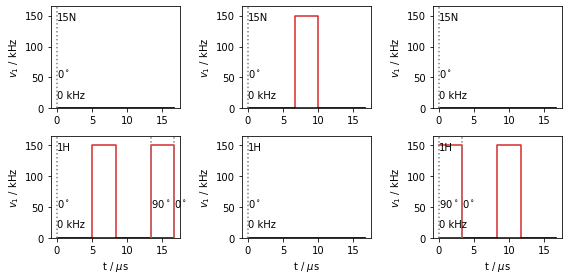

In [3]:
fig,ax=plt.subplots(2,3)
first.plot(ax=ax.T[0])
center.plot(ax=ax.T[1])
second.plot(ax=ax.T[2])
fig.set_size_inches([8,4])
fig.tight_layout()

In [323]:
Ucenter=center.U()
Ufirst=first.U()
Usecond=second.U()

In [326]:
rho=sl.Rho('15Nx','15Nx')
U1=L.Ueye()
U2=L.Ueye()

t0=time()
for k in range(32):
    rho.reset()
    (U2*Ucenter*U1*rho)()
    U1=Ufirst*U1
    U2=Usecond*U2
print(time()-t0)

2.0048940181732178


<IPython.core.display.Javascript object>


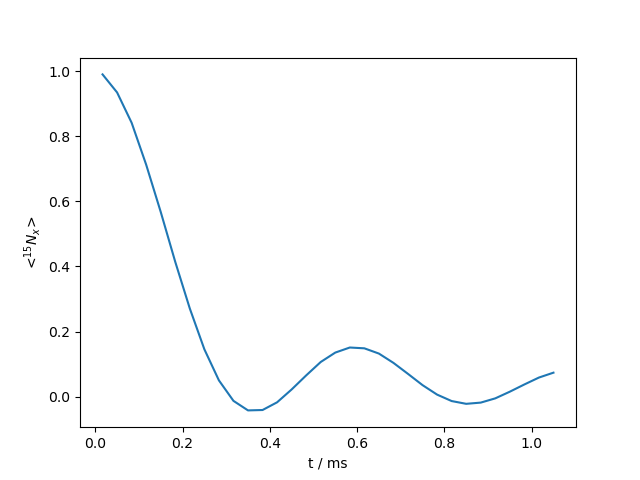

In [327]:
ax=rho.plot()

### Reducible sequence
The above sequence is computational expensive, requiring a basis set of 48 elements. If we consider that we're mainly interested in the $S^+$ operator of the $^{15}$N spin, then its worth noting that the $^{15}$N $\pi$-pulse in the middle of the sequence converts $S^+$ into $S^-$, $S^\alpha$, and $S^\beta$, so that if we could get rid of it, we could use a basis set 1/4 as big (12 elements). Since there is no isotropic $^{15}$N shift included, we can switch the channel of the middle pulse to $^1$H. An alternative approach would be to use a $\delta$-pulse on $^{15}$N, although the basis set would then only be reduced to 24 elements, since $S^+$ would still be converted to $S^-$

In [328]:
centerH=L.Sequence().add_channel('1H',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],v1=[0,v1,0])

rho=sl.Rho('15Np','15Nx')

rho,f,s,c,Ueye=rho.ReducedSetup(first,second,centerH,L.Ueye())

State-space reduction: 48->12


In [329]:
Ufirst=f.U()
Usecond=s.U()
Ucenter=c.U()

In [ ]:
U1=Ueye
U2=Ueye

t0=time()
for k in range(32):
    rho.reset()
    (U2*Ucenter*U1*rho)()
    U1=Ufirst*U1
    U2=Usecond*U2
print(time()-t0)

<IPython.core.display.Javascript object>


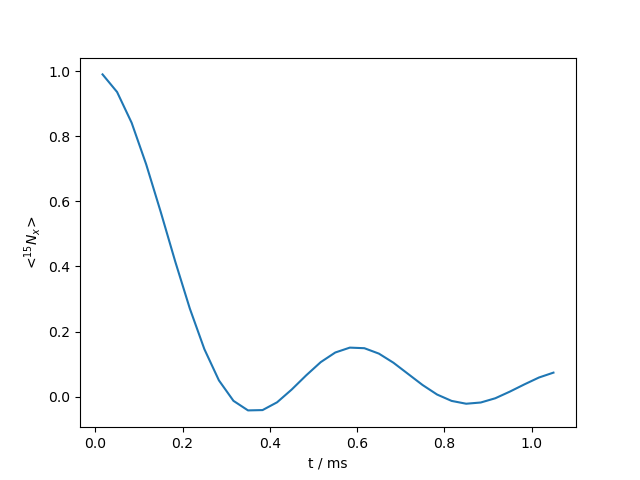

<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

In [336]:
rho.plot()

## Sweep the correlation time

In [337]:
rho_list=[]
legend=[]
t0=time()
for tc in np.logspace(-6,-3,8):
    L.kex=sl.Tools.nSite_sym(n=3,tc=tc)

    t=[0,L.taur/2-tp,L.taur/2,L.taur-tp,L.taur]
    first=L.Sequence().add_channel('1H',t=t,v1=[0,v1,0,v1],phase=[0,0,0,np.pi/2])
    t=[0,tp,L.taur/2,L.taur/2+tp,L.taur]
    second=L.Sequence().add_channel('1H',t=t,v1=[v1,0,v1,0],phase=[0,0,np.pi/2,0])
    centerH=L.Sequence().add_channel('1H',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],v1=[0,v1,0])

    rho_list.append(sl.Rho('15Np','15Nx'))

    rho_list[-1],f,s,c,Ueye=rho_list[-1].ReducedSetup(first,second,centerH,L.Ueye())

    Ufirst=f.U()
    Usecond=s.U()
    Ucenter=c.U()

    U1=Ueye
    U2=Ueye

    for k in range(24):
        rho_list[-1].reset()
        (U2*Ucenter*U1*rho_list[-1])()
        
        U1=Ufirst*U1
        U2=Usecond*U2

    legend.append(fr'$\log_{{10}}(\tau_c)$ = {np.log10(tc):.1f}')
    print(f'log10(tc /s) = {np.log10(tc):.1f}, {time()-t0:.0f} seconds elapsed')

State-space reduction: 48->12
log10(tc /s) = -6, 30 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -6, 60 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -5, 88 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -5, 118 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -4, 146 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -4, 176 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -3, 206 seconds elapsed
State-space reduction: 48->12
log10(tc /s) = -3, 237 seconds elapsed


<IPython.core.display.Javascript object>


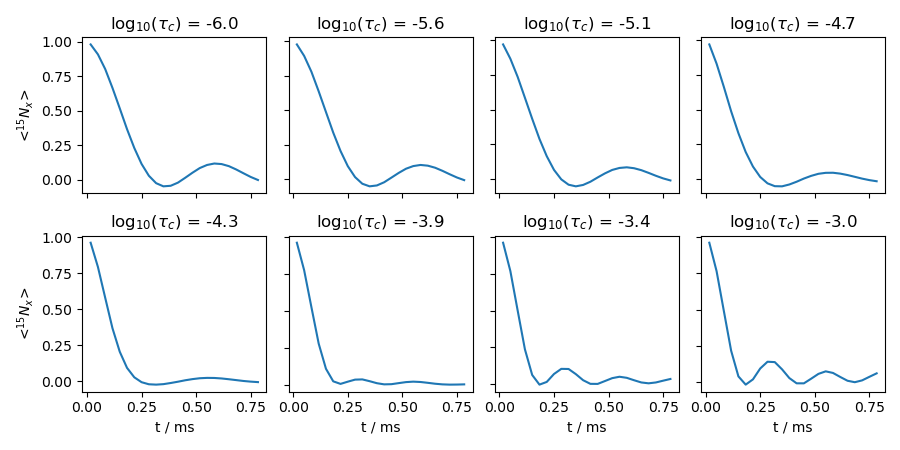

In [340]:
fig,ax=plt.subplots(2,4)
ax=ax.flatten()
for a,l,r in zip(ax,legend,rho_list):
    r.plot(ax=a)
    a.set_title(l)
    if not(a.is_first_col()):
        a.set_ylabel('')
        a.set_yticklabels([])
    if not(a.is_last_row()):
        a.set_xlabel('')
        a.set_xticklabels([])
fig.set_size_inches([9,4.5])
fig.tight_layout()